In this notebook, I explore my new idea of employing only Z correction of phase error amplified by APE sequence

### References

^[1]: Lucero10

## Dependencies

In [1]:
%config InlineBackend.figure_formats = ['svg']

import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

## Derivative Removal of Adiabaticity Gates

[1]: Sheldon *et al.* Characterizing errors on qubit operations via iterative randomized benchmarking. *Phys. Rev. A* **93**, 012301. [https://doi.org/10.1103/PhysRevA.93.012301](https://doi.org/10.1103/PhysRevA.93.012301).

Transmon systems are, theoretically, weakly anharmonic oscillators with extra dimensions whose presence is unfavorred in the context of quantum computing. They can cause leakage (real transitions) or phase error (virtual transitions) on the computational subspace. To remove leakage, Derivative Removal of Adiabatic Gate (DRAG) technique is employed. **Try running simulations to see the effect of DRAG.**

The weak anharmonictity of transmons, $\Delta$, limits the control pulses' length. Because the coherent time of transmon qubits is finite, Heisenberg principle dictates that the pulse should not be proportionally shorter than the inverse of anharmonicity, $1/\Delta$. **We should run some experiments to confirm this.** Longer pulses are limited by the generic coherent time of the qubits themselves. 

Repetitive interleaved randomized benchmarking means: repeating a target Clifford $n$ times between the random Clifford gates and measuring the fidelity as a function of $n$ repetitions. Two cases might arise

- If the gate errors are non-unitary, then the fidelity will only depend on the total length of the interleaved segment, and the resulting error per segment will thus be *linear* with $n$.
- If there are unitary errors of an over-/underrotation type, they will add coherently with $n$, and the fidelity decay will be *quadratic* to leading order.

In [2]:
provider = IBMProvider()
print(provider.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>]


In [3]:
backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

In [4]:
qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
qubit_12_freq = qubit_01_freq + qubit_anharmonicty

p12_amp = 0.22289722723304814

In [5]:
with pulse.build(backend=backend) as hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp/2, sigma=24, beta=-0.4, name='hp12'), drive_chan)
    
hp12_gate = Gate(r'X_{\pi/2}^{(12)}', weight, [])
    
with pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp, sigma=24, beta=-0.4, name='p12'), drive_chan)

p12_gate = Gate(r'X_{\pi}^{(12)}', weight, [])

In [6]:
with pulse.build(backend=backend) as delay_5us:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(10000, drive_chan)
    
with pulse.build(backend=backend) as delay_10us:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(20000, drive_chan)
    
delay_gate = Gate('Delay', weight, [])

## Discriminator

In [7]:
ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.append(delay_gate, [qubit])
ground_circ.measure(qubit, cbit)
ground_circ.add_calibration(delay_gate, [qubit], delay_10us)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.append(delay_gate, [qubit])
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)
first_excited_state_circ.add_calibration(delay_gate, [qubit], delay_5us)

second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.append(delay_gate, [qubit])
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(p12_gate, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(p12_gate, [qubit], p12_sched)
second_excited_state_circ.add_calibration(delay_gate, [qubit], delay_5us)

discrim_circs = qiskit.transpile([ground_circ, first_excited_state_circ, second_excited_state_circ], backend=backend)

## Only Z correction

Amplified phase error (APE) pulse sequence in combination with Z component.

In [47]:
detuning_MHz = np.linspace(-5, 5.0, 100)
detuning_MHz = detuning_MHz*MHz

In [48]:
Z_circs = []

for detuning in detuning_MHz:

    Z_circ = QuantumCircuit(num_qubits, num_cbits)
    Z_circ.append(delay_gate, [qubit])
    Z_circ.x(qubit) # prepare |1>
    Z_circ.append(hp12_gate, [qubit])

    with pulse.build(backend=backend) as hp12_sched_Z:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_12_freq+detuning, drive_chan)
        pulse.play(pulse.Drag(duration=96, amp=p12_amp/2, sigma=24, beta=-0.4, name='hp12_YZ'), drive_chan)

    hp12_gate_Z = Gate(r'R_{\pi/2}^{(12)}', weight, [])

    # n = 5 i.e. 1 pseudo sequence of I
    Z_circ.append(hp12_gate_Z, [qubit])
    Z_circ.append(hp12_gate_Z, [qubit])
    Z_circ.append(hp12_gate_Z, [qubit])
    Z_circ.append(hp12_gate_Z, [qubit])
    Z_circ.append(hp12_gate_Z, [qubit])
    Z_circ.append(hp12_gate_Z, [qubit])
    Z_circ.append(hp12_gate_Z, [qubit])
    Z_circ.append(hp12_gate_Z, [qubit])

    Z_circ.append(hp12_gate, [qubit])

    Z_circ.measure(qubit, cbit)

    Z_circ.add_calibration(delay_gate, [qubit], delay_5us)
    Z_circ.add_calibration(hp12_gate, [qubit], hp12_sched)
    Z_circ.add_calibration(hp12_gate_Z, [qubit], hp12_sched_Z)

    Z_circs.append(Z_circ)

In [49]:
package = []

package = discrim_circs + Z_circs

In [50]:
Z_exp_2 = backend.run(package, meas_level=1, meas_return='single', shots=2048)

In [91]:
jobs = provider.jobs(limit=20, descending=True, status='pending')

In [92]:
jobs

[<IBMCircuitJob('cp0t8bs2zy6g008s367g')>,
 <IBMCircuitJob('cp0t82gprheg008qez9g')>]

In [61]:
print(Z_exp.job_id(), Z_exp.status())

cp0ms7wja3gg0085mqt0 JobStatus.DONE


In [88]:
print(Z_exp_2.job_id(), Z_exp_2.status())

cp0t8bs2zy6g008s367g JobStatus.QUEUED


In [96]:
Z_exp = provider.backend.retrieve_job('cp0t8bs2zy6g008s367g')

In [97]:
Z_data = DataAnalysis(experiment=Z_exp, average=False, shots=2048, qubit=0)
Z_data.retrieve_data(average=False)
Z_data.build_discrim()
Z_data.count_pop()
Z_data.error_mitiq()

In [98]:
Z_data_1D_wD = Z_data.mitiq_data[3:, 2]

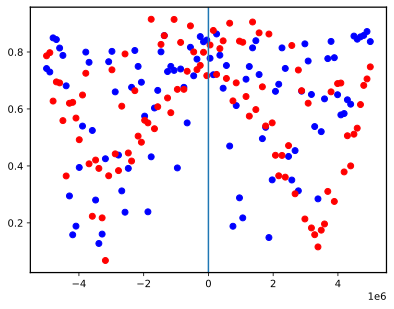

In [100]:
plt.scatter(detuning_MHz, Z_data_1D_woD, color='b')
plt.scatter(detuning_MHz, Z_data_1D_wD, color='r')
plt.axvline(0)

In [102]:
import pickle
with open('./calibrator/onlyZ/data/19dec/Z_data_1D_woD_m5_5MHz.pkl', 'wb') as f:
    pickle.dump(Z_data_1D_woD, f)